<a href="https://colab.research.google.com/github/matheusTA/detecting-pathologies-lungs/blob/main/detected_without_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importando bibliotecas

In [1]:
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Conectando com o google drive para baixar dataset

In [2]:
drive.mount("/content/gdrive")

path = '/content/gdrive/MyDrive/dataset/'

Mounted at /content/gdrive


### Carregando as imagens com data augmentation

In [3]:
data_generator_train = ImageDataGenerator(rescale = 1./255)

data_generator_test = ImageDataGenerator(rescale = 1./255)

In [4]:
train_generator = data_generator_train.flow_from_directory(
    directory = path + 'train',
    target_size = (120, 120),
    color_mode = "grayscale",
    class_mode = "categorical",
    batch_size = 32,
    seed = 42,
    shuffle = True
)

Found 7097 images belonging to 4 classes.


In [5]:
test_generator = data_generator_test.flow_from_directory(
    directory = path + 'test',
    target_size = (120, 120),
    color_mode = "grayscale",
    class_mode = "categorical",
    batch_size = 32,
    seed = 42,
    shuffle = True
)

Found 771 images belonging to 4 classes.


In [6]:
valid_generator = data_generator_test.flow_from_directory(
    directory = path + 'val',
    target_size = (120, 120),
    color_mode = "grayscale",
    class_mode = None,
    batch_size = 1,
    seed = 42,
    shuffle = False
)

Found 38 images belonging to 4 classes.


### Criação do modelo

In [7]:
model = Sequential()

model.add(Conv2D(kernel_size=(3,3), filters=32, activation='relu', input_shape=(120, 120, 1)))
model.add(MaxPool2D(2,2))

model.add(Conv2D(kernel_size=(3,3), filters=64, activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(kernel_size=(3,3), filters=128, activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 128)      0

### Definindo hiperparâmetros

In [8]:
EPOCHS = 15
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

### Treiando o modelo

In [9]:
model_history = model.fit(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=test_generator,
    validation_steps=STEP_SIZE_TEST,
    epochs=EPOCHS,
    verbose= 1
)

Epoch 1/15
221/221 [==============================] - 4728s 21s/step - loss: 0.4496 - accuracy: 0.8266 - val_loss: 0.4286 - val_accuracy: 0.8333
Epoch 2/15
221/221 [==============================] - 110s 499ms/step - loss: 0.2315 - accuracy: 0.9179 - val_loss: 0.4057 - val_accuracy: 0.8438
Epoch 3/15
221/221 [==============================] - 109s 494ms/step - loss: 0.1815 - accuracy: 0.9355 - val_loss: 0.3194 - val_accuracy: 0.8750
Epoch 4/15
221/221 [==============================] - 108s 488ms/step - loss: 0.1523 - accuracy: 0.9456 - val_loss: 0.3142 - val_accuracy: 0.8672
Epoch 5/15
221/221 [==============================] - 108s 490ms/step - loss: 0.1254 - accuracy: 0.9524 - val_loss: 0.1886 - val_accuracy: 0.9297
Epoch 6/15
221/221 [==============================] - 108s 489ms/step - loss: 0.1030 - accuracy: 0.9663 - val_loss: 0.1728 - val_accuracy: 0.9297
Epoch 7/15
221/221 [==============================] - 108s 489ms/step - loss: 0.0891 - accuracy: 0.9670 - val_loss: 0.2284 - 

### Avaliando o modelo nos dados de teste

In [10]:
model.evaluate(test_generator, steps=STEP_SIZE_TEST)

24/24 [==============================] - 11s 455ms/step - loss: 0.0157 - accuracy: 0.9935


[0.015695346519351006, 0.9934895634651184]

### Salvando modelo

In [11]:
model.save("XrayClassification")

INFO:tensorflow:Assets written to: XrayClassification/assets


### Gráfico de ACC

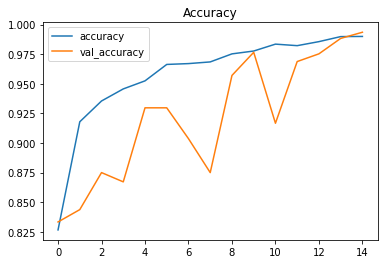

In [12]:
pd.DataFrame(model_history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy") 
plt.show()

### Gráfico de LOSS

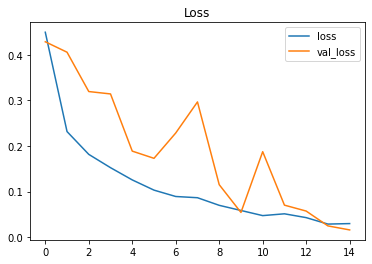

In [13]:
pd.DataFrame(model_history.history)[['loss','val_loss']].plot()
plt.title("Loss") 
plt.show() 

### Matriz de confusão

38/38 [==============================] - 24s 631ms/step


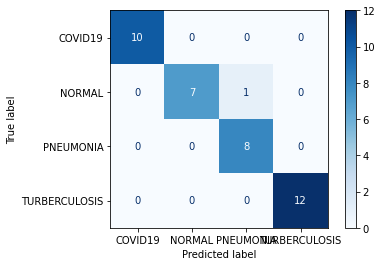

In [14]:
valid_generator.reset()

pred = model.predict(valid_generator, steps=STEP_SIZE_VALID, verbose=1)

predicted_class_indices = np.argmax(pred, axis=1)

target_names = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']

cllt = confusion_matrix(valid_generator.classes, predicted_class_indices)
disp = ConfusionMatrixDisplay(confusion_matrix=cllt, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.show()

### Critérios de avaliação

In [15]:
print(classification_report(valid_generator.classes, predicted_class_indices, target_names=target_names))

               precision    recall  f1-score   support

      COVID19       1.00      1.00      1.00        10
       NORMAL       1.00      0.88      0.93         8
    PNEUMONIA       0.89      1.00      0.94         8
TURBERCULOSIS       1.00      1.00      1.00        12

     accuracy                           0.97        38
    macro avg       0.97      0.97      0.97        38
 weighted avg       0.98      0.97      0.97        38



### ACC nas imagens de validação

In [16]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

current_idx = 0
count_accurate = 0
Actual = []

for i in predictions:
    string = valid_generator.filenames[current_idx]
    substr = '/'
    actual = string[:string.find(substr)]
    Actual.append(actual)
    pred = predictions[current_idx]
    if actual == pred: 
        count_accurate += 1
    current_idx += 1

acc = count_accurate/38

print(f"A acc nas imagens de validação é {round(acc*100,2)}%.")

A acc nas imagens de validação é 97.37%.


### Exibindo resultados

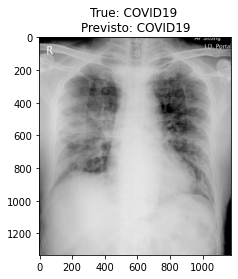

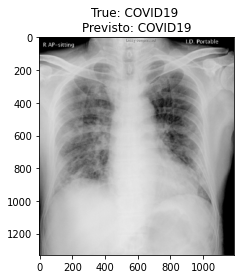

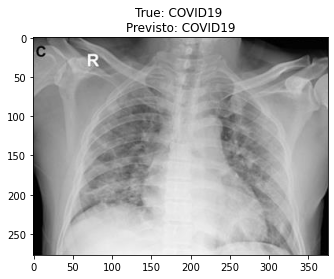

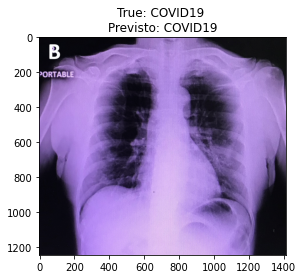

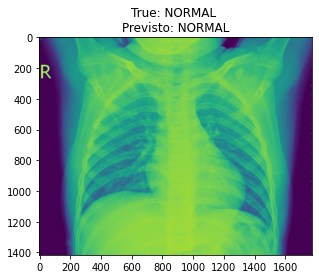

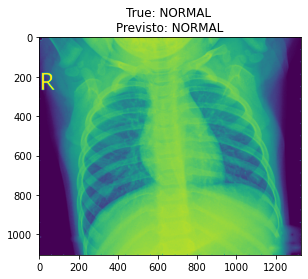

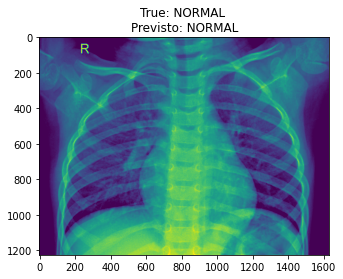

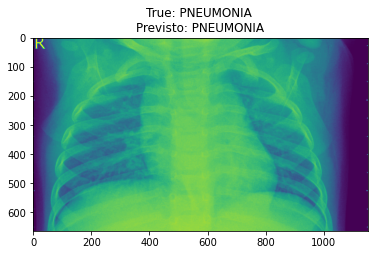

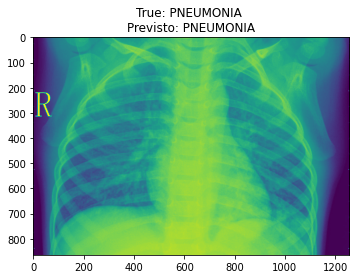

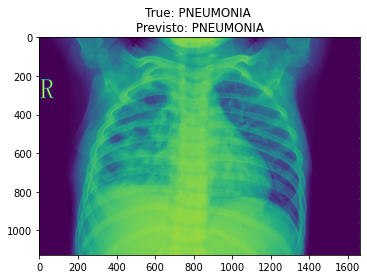

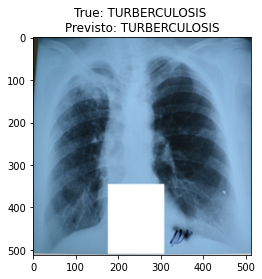

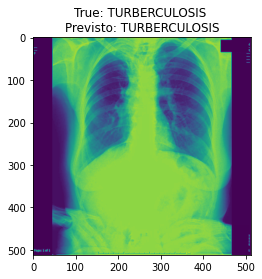

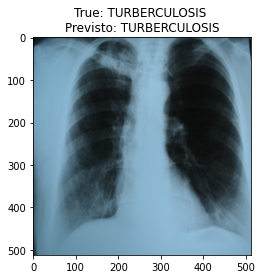

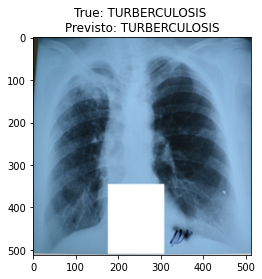

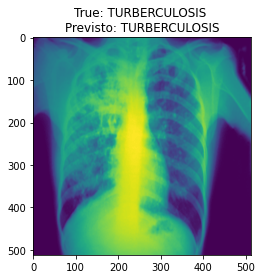

In [17]:
current = [1, 2, 3, 5, 10, 15, 16, 20, 22, 25, 28, 30, 33, 35, 37]

for i in current: 
    plt.imshow(plt.imread(path + 'val/' + valid_generator.filenames[i]))
    string = valid_generator.filenames[i]
    substr = '/'
    actual = string[:string.find(substr)]
    plt.title(f"True: {actual} \nPrevisto: {predictions[i]}")
    plt.show()